In [ ]:
# get all data
# identify all points on pad sites
# convert time to dates
# get unique users
# get unique dates
# iterate over each user and day
# dbscan to id events
# get user's name from worker fl
# get center, start time, stop time, duration of each event
# missing times
# return to same site on same day
# most traveled roads
# analyze results
# reduce smaller clusters to single points
## snap to roads
## create route
## how much time, distance?
## most efficient route
# site visit history - last visit, by who, how long

In [1]:
from arcgis.gis import GIS
import pandas as pd
import numpy as np
import json
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
%matplotlib notebook
import pytz
import getpass

In [2]:
# gis object
password = getpass.getpass()
gis = GIS(username = 'jason_cnx',
          password = password)

········


In [20]:
# get layers needed
tracks_id = "619be0d131594c579132caf247802c15"
cluster_id = "0af1d86ee5bf4bc3ac38849c3119a7d8"

# get tracks layer
tracks_item = gis.content.get(tracks_id)
tracks_layer = tracks_item.layers[0]

# get cluster layer, for results
cluster_item = gis.content.get(cluster_id)
cluster_layer = cluster_item.layers[0]

In [21]:
# query for all features
track_features = tracks_layer.query(where="Creator = 'lss0wos_consol'", out_fields="*")
# And CreationDate > '2018-10-12 00:00:00' And CreationDate < '2018-10-13 00:00:00'

In [22]:
# convert query featureset to spatially enabled dataframe
# requires arcgis v1.5 or later
df = track_features.sdf

In [23]:
# set globalid as index
# this will allow update of cluster field in main dataframe
df.set_index('GlobalID', inplace=True, drop=False)

In [24]:
# add cluster column
df["cluster"] = -2

In [25]:
# convert CreationDate to datetime
df['CreationDate'] = pd.to_datetime(df['CreationDate'], unit='ms')

In [26]:
# convert timezone
#TODO: confirm this matches what is on AGO
utc = pytz.utc
eastern = pytz.timezone('US/Eastern')

def convert_timezone(date):
    return utc.localize(date).astimezone(eastern)

def convert_date(date):
    return date.date()

def convert_to_string(date):
    return date.strftime("%Y-%m-%d")

df['dt_tz'] = df['CreationDate'].apply(convert_timezone)
df['date_tz'] = df['dt_tz'].apply(convert_date)
df['date_string'] = df['dt_tz'].apply(convert_to_string)

In [27]:
# populate columns for x and y
def get_x(shape):
    return shape['x']
def get_y(shape):
    return shape['y']

df['x'] = df['SHAPE'].apply(get_x)
df['y'] = df['SHAPE'].apply(get_y)

In [28]:
df.head()

,Accuracy,CreationDate,Creator,EditDate,Editor,GlobalID,OBJECTID,SHAPE,cluster,dt_tz,date_tz,date_string,x,y
GlobalID,,,,,,,,,,,,,,
1ae4d8a4-5345-4a85-a621-08db981458db,5.360,2018-10-04 12:58:21.789999962,lss0wos_consol,2018-10-04 12:58:21.789999962,lss0wos_consol,1ae4d8a4-5345-4a85-a621-08db981458db,105397,"{""x"": -8852408.7596, ""y"": 4944335.161600001, ""...",-2,2018-10-04 08:58:21.789999962-04:00,2018-10-04,2018-10-04,-8.852409e+06,4.944335e+06
98ed68b3-4b02-4bfb-b719-a1bdda58577f,3.000,2018-10-04 12:58:52.052000046,lss0wos_consol,2018-10-04 12:58:52.052000046,lss0wos_consol,98ed68b3-4b02-4bfb-b719-a1bdda58577f,105400,"{""x"": -8852413.1901, ""y"": 4944326.9736, ""spati...",-2,2018-10-04 08:58:52.052000046-04:00,2018-10-04,2018-10-04,-8.852413e+06,4.944327e+06
ce2c978e-0a5f-46c1-baf9-2994aa88d002,3.000,2018-10-04 12:59:21.854000092,lss0wos_consol,2018-10-04 12:59:21.854000092,lss0wos_consol,ce2c978e-0a5f-46c1-baf9-2994aa88d002,105403,"{""x"": -8852416.2402, ""y"": 4944328.980300002, ""...",-2,2018-10-04 08:59:21.854000092-04:00,2018-10-04,2018-10-04,-8.852416e+06,4.944329e+06
5bee70e5-f123-4e62-b3f6-2955e61f9aff,3.000,2018-10-04 12:59:51.963999987,lss0wos_consol,2018-10-04 12:59:51.963999987,lss0wos_consol,5bee70e5-f123-4e62-b3f6-2955e61f9aff,105406,"{""x"": -8852421.027, ""y"": 4944331.572899997, ""s...",-2,2018-10-04 08:59:51.963999987-04:00,2018-10-04,2018-10-04,-8.852421e+06,4.944332e+06
98fb1624-712c-4150-b089-cb7fd73bcf15,3.153,2018-10-04 13:00:22.055000067,lss0wos_consol,2018-10-04 13:00:22.055000067,lss0wos_consol,98fb1624-712c-4150-b089-cb7fd73bcf15,105409,"{""x"": -8852443.2797, ""y"": 4944331.646200001, ""...",-2,2018-10-04 09:00:22.055000067-04:00,2018-10-04,2018-10-04,-8.852443e+06,4.944332e+06


In [29]:
# confirm dates look right
df.groupby("date_tz")["date_tz"].count()

date_tz
2018-10-04    1073
2018-10-05    1396
2018-10-06    1414
2018-10-07    1451
2018-10-11     674
2018-10-12    1424
2018-10-13    1441
2018-10-14    1426
2018-10-15    1477
2018-10-16    1761
2018-10-17     710
2018-10-20    1378
2018-10-21    1381
2018-10-22    1445
2018-10-23    1384
2018-10-24    1479
2018-10-25    1480
2018-10-29     724
2018-10-30    1447
2018-10-31    1432
2018-11-01     708
2018-11-07    1444
2018-11-08    1444
2018-11-10    1387
2018-11-11    1434
2018-11-12    1457
2018-11-16     685
2018-11-17    1573
2018-11-18    1455
2018-11-19     463
Name: date_tz, dtype: int64

In [30]:
# get unique dates and workers
dates = np.unique(df['date_tz'])
workers = np.unique(df['Creator'])

In [31]:
eps = [45.72, 60.96, 76.2]   # unit: latitude/longitude 100-400
min_sample = [8, 12]
n1, n2 = len(eps), len(min_sample)

In [33]:
# filter df2 by worker and date
count = 0
for worker in workers:
    for date in dates:
        
        for i in range(n1):
            for j in range(n2):
                
                print(date)
                print("eps: {} - min_sample: {}".format(eps[i], min_sample_[j]))
                
                # new df for processing
                df2 = df.loc[(df['Creator'] == worker) & (df['date_tz'] == date)]
                
                # spatial join to pads
                

                # get arrays of y, x
                X = df2[['y', 'x']].values
                db = DBSCAN(eps=eps[i], min_samples=min_sample[j], metric="euclidean").fit(X)

                labels = db.labels_
                n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
                print("count: {}".format(n_clusters_))

                # add cluster info to df2
                df2['cluster'] = db.labels_.tolist()

                # pull cluster out
                df3 = df2['cluster']

                # update df
                # df.update(df3)

                # features to ago
                features = []

                for index, row in df2.iterrows():
                    feature = {"attributes": 
                           {"username": row["Creator"],
                            "capture_time": row["CreationDate"],
                            "original_globalid": row["GlobalID"],
                            "cluster": row["cluster"],
                            "eps": eps[i],
                            "capture_time_date": row['date_string'],
                            "min_samples": min_sample[j]}, 
                           "geometry": row['SHAPE']}
                    features.append(feature)
                
                add_result = cluster_layer.edit_features(adds = features)
        
print(count)

2018-10-04
count: 5
2018-10-04
count: 4
2018-10-04
count: 5
2018-10-04
count: 5
2018-10-04
count: 6
2018-10-04
count: 5
2018-10-05
count: 11
2018-10-05
count: 9
2018-10-05
count: 11
2018-10-05
count: 8
2018-10-05
count: 10
2018-10-05
count: 8
2018-10-06
count: 11
2018-10-06
count: 8
2018-10-06
count: 12
2018-10-06
count: 8
2018-10-06
count: 12
2018-10-06
count: 8
2018-10-07
count: 15
2018-10-07
count: 12
2018-10-07
count: 14
2018-10-07
count: 10
2018-10-07
count: 14
2018-10-07
count: 10
2018-10-11
count: 2
2018-10-11
count: 2
2018-10-11
count: 1
2018-10-11
count: 1
2018-10-11
count: 1
2018-10-11
count: 1
2018-10-12
count: 7
2018-10-12
count: 5
2018-10-12
count: 7
2018-10-12
count: 5
2018-10-12
count: 8
2018-10-12
count: 5
2018-10-13
count: 11
2018-10-13
count: 9
2018-10-13
count: 13
2018-10-13
count: 9
2018-10-13
count: 14
2018-10-13
count: 9
2018-10-14
count: 10
2018-10-14
count: 9
2018-10-14
count: 8
2018-10-14
count: 7
2018-10-14
count: 8
2018-10-14
count: 7
2018-10-15
count: 9
2018

In [24]:
df2.groupby('cluster')['cluster'].count()

cluster
-1.0     5457
 0.0    14545
 1.0     5624
 2.0     3648
 3.0     2979
 4.0     1362
 5.0     1609
 6.0      796
 7.0      151
 8.0       68
Name: cluster, dtype: int64

In [41]:
df2.to_featurelayer("clustering_resultrs",gis)

Exception: Cannot Export the data without ArcPy or PyShp modules. Please install them and try again.

<IPython.core.display.Javascript object>


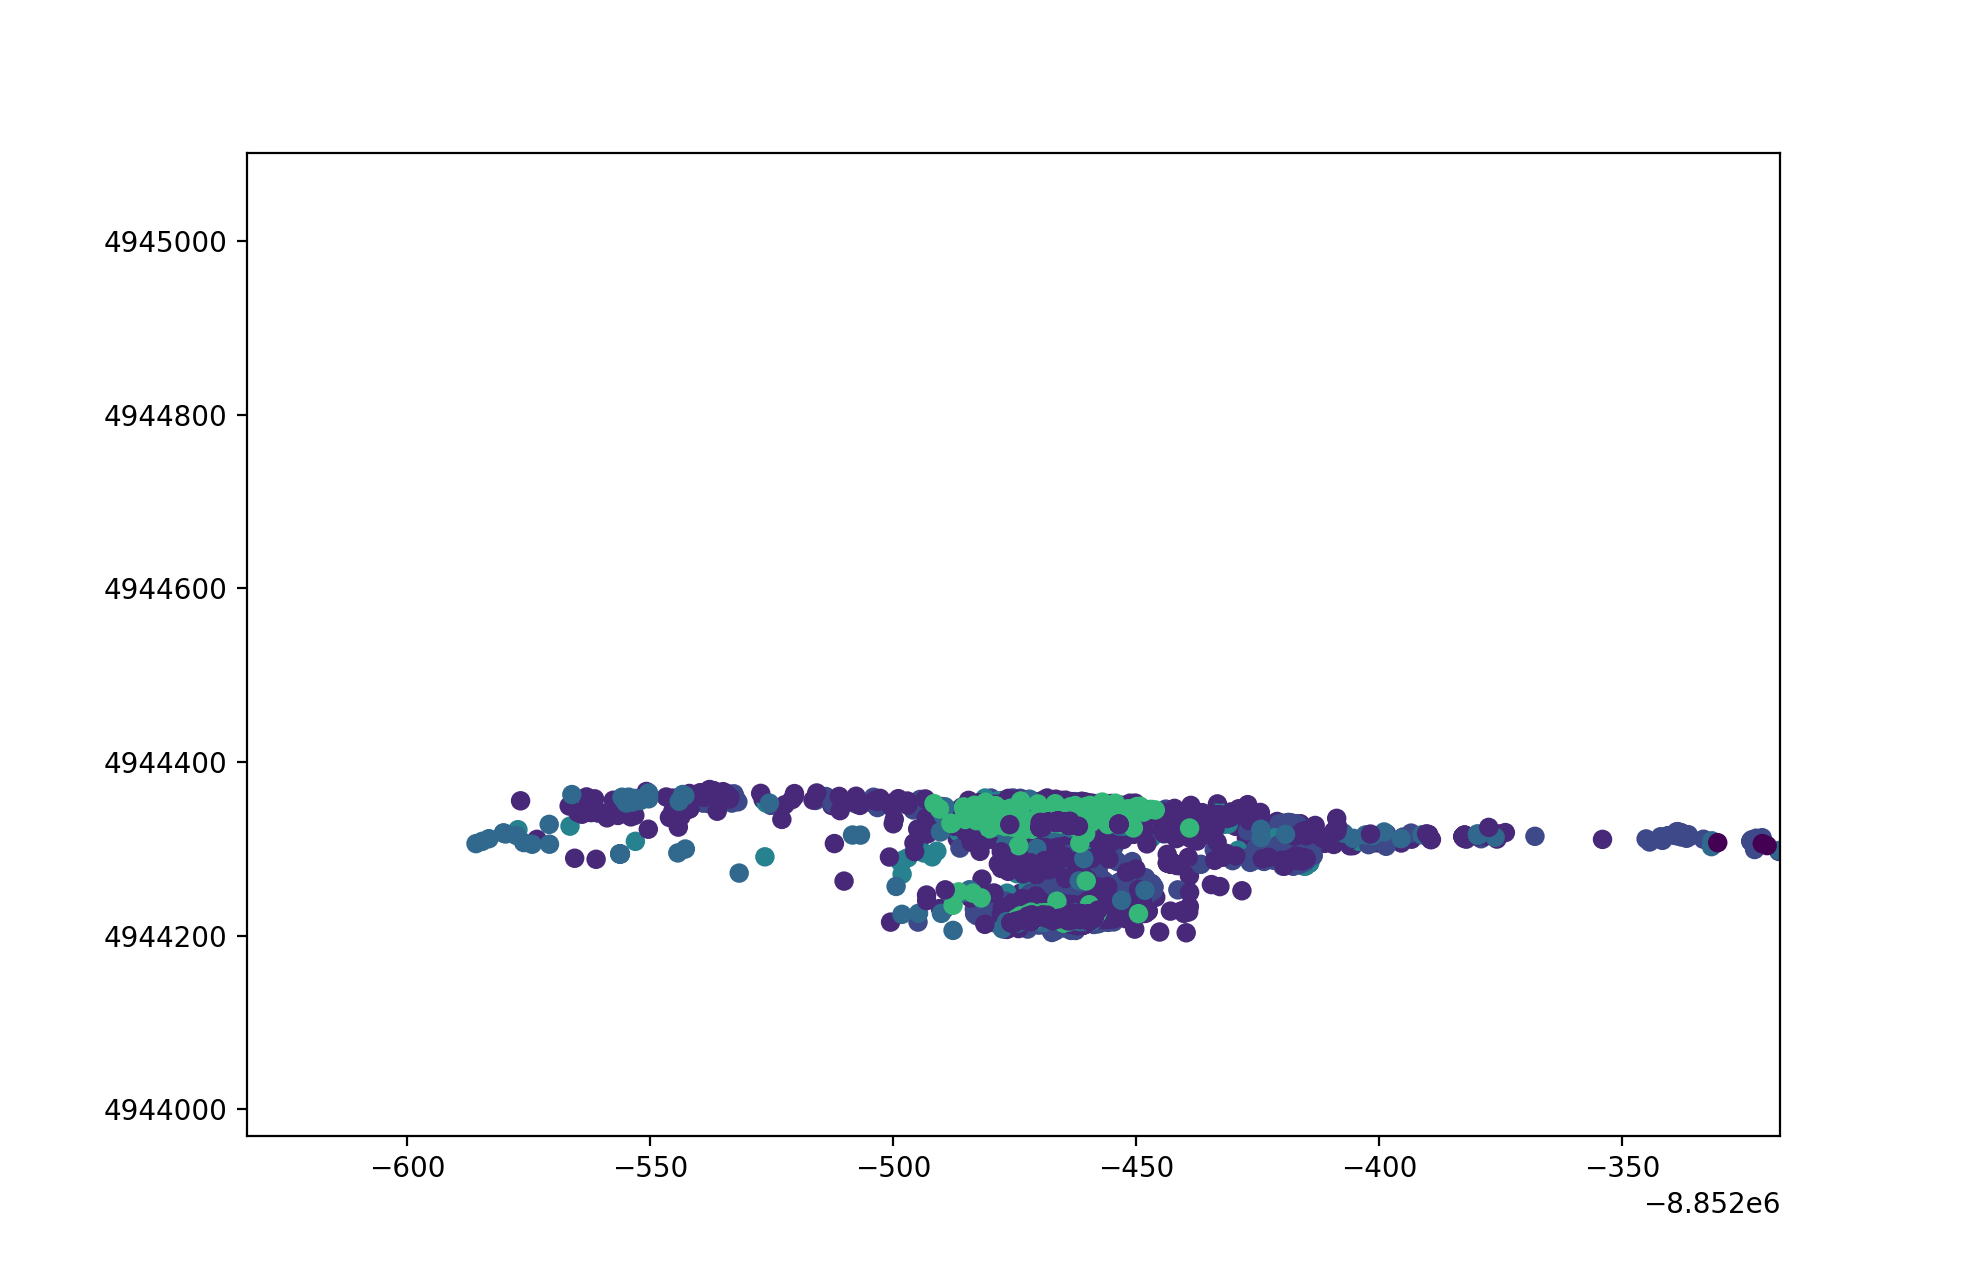

In [26]:
# plot x, y
plt.scatter(df2['x'], df2['y'], c=df2['cluster'])
plt.show()

In [37]:
m1 = GIS().map('United States')
df.plot(map_widget=m1)
m1

<IPython.core.display.Javascript object>

AttributeError: Unknown property map_widget

In [36]:
df.plot(map_widget=m1)

<IPython.core.display.Javascript object>

AttributeError: Unknown property map_widget

In [ ]:
# get arrays of y, x
X = df[['y', 'x']].values
db = DBSCAN(eps=91.44, min_samples=15, metric="euclidean").fit(X)
np.unique(db.labels_)

In [32]:
dir(df)

['Accuracy',
 'CreationDate',
 'Creator',
 'EditDate',
 'Editor',
 'JSON',
 'OBJECTID',
 'SHAPE',
 'T',
 'WKB',
 'WKT',
 '_AXIS_ALIASES',
 '_AXIS_IALIASES',
 '_AXIS_LEN',
 '_AXIS_NAMES',
 '_AXIS_NUMBERS',
 '_AXIS_ORDERS',
 '_AXIS_REVERSED',
 '_AXIS_SLICEMAP',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_wrap__',
 '__bool__',
 '__bytes__',
 '__class__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__feature_set__',
 '__finalize__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__geo_interface__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__invert__',
 '__ipow__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__le__',
 '__len__',
 '__lt__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pow__',
 '__radd__',
 '_

In [ ]:
# add labels as new column in df
df['cluster'] = db.labels_.tolist()
df.head()

In [ ]:
# plot x, y
plt.scatter(df['x'], df['y'], c=df['cluster'])
plt.show()


In [ ]:
# get min max of each cluster, creation date
cluster_min_dt = df.groupby('cluster')['CreationDate'].min()
cluster_max_dt = df.groupby('cluster')['CreationDate'].max()
cluster_max_dt

In [ ]:

eps = [30.48, 45.72, 60.96, 76.2, 91.44, 106.68, 121.92]   # unit: latitude/longitude 100-400
min_sample = [5, 8, 12, 15, 18, 21]
n1, n2 = len(eps), len(min_sample)
plt.subplots(nrows=n1, ncols=n2, figsize=(20, 15))
ax.scatter(lons, lats, marker = 'o', color=color, edgecolor='gray', zorder=5, alpha=1.0, s=15)
for i in range(n1):
    for j in range(n2):
        est = DBSCAN(eps=eps[i], min_samples=min_sample[j], metric="euclidean").fit(X)
        df2['oid'] = est.labels_.tolist()

        ax = plt.subplot(n1, n2, n2*i+j+1)
        ax.set_title("DBSCAN ('euclidean', eps={}, min_sample={})".format(eps[i], min_sample[j]))
        
        # plot_stations_map(ax, works_data)

In [ ]:
est[]

In [ ]:
X
len(X)

In [ ]:
est1 = DBSCAN(eps=91.44, min_samples=15, metric="euclidean").fit(X)
np.unique(est1.labels_)

In [ ]:
est1.core_sample_indices_

In [ ]:
len(est1.components_)

In [ ]:
y_list = [x[0] for x in est1.components_]
y_list
x_list = [x[1] for x in est1.components_]
len(x_list)

In [ ]:
plt.scatter(x_list, y_list)
plt.show()

In [ ]:
df2.to_featureclass(out_location=r"C:\Users\jaso9356\Desktop\dev\py\cnx\test.gdb",
                   out_name="df_test3")

In [ ]:
# Log into ArcGIS anonymously
g = GIS()
# Retrieve an item from ArcGIS Online from a known ID value
known_item = g.content.get("85d0ca4ea1ca4b9abf0c51b9bd34de2e")
known_item

# Obtain the first feature layer from the item
fl = known_item.layers[0]

# Use the `from_layer` method of the Spatial DataFrame to create a new Spatial DataFrame
sdf = SpatialDataFrame.from_layer(fl)

# Return the first 5 records. 
sdf.head()


sdf.to_featureclass(out_location=r"path\to\your\data\output_example",
                   out_name="output_cities.shp")

In [ ]:
def plot_stations_map(ax, stns):
    # determine range to print based on min, max lat and lon of the data
    lat = list(stns['y'])
    lon = list(stns['x'])
    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin

    # create map using BASEMAP
    m = Basemap(llcrnrlon=lon_min,
                llcrnrlat=lat_min,
                urcrnrlon=lon_max,
                urcrnrlat=lat_max,
                lat_0=(lat_max - lat_min)/2,
                lon_0=(lon_max - lon_min)/2,
                projection='lcc',
                resolution = 'f',)

    m.drawcoastlines()
    m.fillcontinents(lake_color='aqua')
    m.drawmapboundary(fill_color='aqua')
    m.drawrivers()    
    
    # plot points
    clist = list(stns['cluster'].unique())
    if -1 in clist:
        clist.remove(-1)
    k = len(clist)
    colors = iter(cm.Set1(np.linspace(0, 1, max(10, k))))
    for i in range(k):
        color = next(colors)
        df = stns.loc[stns['cluster'] == clist[i]]        
        #print("Cluster {} has {} samples.".format(clist[i], df.shape[0]))
        
        # convert lat and lon to map projection coordinates
        lons, lats = m(list(df['station longitude']), list(df['station latitude']))        
        ax.scatter(lons, lats, marker = 'o', color=color, edgecolor='gray', zorder=5, alpha=1.0, s=15)